In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DEBUG = False
SUBSET_DIAS = 30

## Tratando os dados

### Importando o dataset e removendo colunas não necessárias

In [2]:
dataset_original = pd.read_csv('data/sei.csv')
logs = pd.read_csv('logs/out/logs-completo.csv', index_col=0)

dataset = dataset_original.merge(logs, how='left', left_on='id_inscricao', right_on='id_inscricao')
dataset

,index,id_inscricao,dt_inscricao,dt_fim_inscricao,sg_uf,tp_sexo,dt_nascimento,sg_pais,id_oferta_x,id_curso,...,acesso_dia_21,acesso_dia_22,acesso_dia_23,acesso_dia_24,acesso_dia_25,acesso_dia_26,acesso_dia_27,acesso_dia_28,acesso_dia_29,acesso_dia_30
0,0,92,2018-02-19 00:00:00,2018-03-12 07:42:00,MG,F,1958-07-28,NaN,26,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,94,2018-02-19 00:00:00,2018-03-12 07:59:00,RJ,M,1973-06-15,NaN,26,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,97,2018-02-19 00:00:00,2018-03-12 08:44:00,MG,F,1949-06-19,NaN,26,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,106,2018-02-19 00:00:00,2018-03-12 09:45:00,DF,M,1984-10-07,NaN,26,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,109,2018-02-19 00:00:00,2018-03-12 10:08:00,TO,F,1978-04-13,NaN,26,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79609,79609,553927,2019-02-27 22:39:00,2019-03-29 23:59:00,MG,F,1978-12-22,BR,852,74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79610,79610,553937,2019-02-27 22:37:00,2019-03-29 23:59:00,RN,F,1967-05-20,BR,852,74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79611,79611,553995,2019-02-27 23:57:00,2019-03-29 23:59:00,AL,M,1981-08-02,BR,852,74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79612,79612,554003,2019-02-27 23:57:00,2019-03-29 23:59:00,PE,M,1983-11-20,BR,852,74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
"""
Para isso, inicialmente iremos melhorar os dados do nosso dataset, removendo alguns atributos considerados 
desnecessários. Primeiramente removeremos os atributos referentes às notas máximas de determinada atividade,
visto que esse valor sempre será 100.
"""

"""
30/03 
Alguns dados defeituosos serão removidos para que não influenciem negativamente os testes

165 => Fez as atividades mas algumas passaram de 1 mês
"""
dataset.drop(index=[165])

# Filtramos todas as colunas do dataset que possuem o valor da nota máxima da atividade X:
notas_maximas_a_remover = dataset.filter(like='nota_maxima_atividade')


# Filtramos também alguns índices e id's que não serão necessários no momento
indices_e_ids_a_remover = [
    "index", 
     "id_inscricao", 
     "id_oferta_x", 
     "id_curso", 
     "qt_carga_horaria_oferta",
     "qt_duracao_dias",
     "id_pessoa",
     "nota_maxima_curso",
     "tx_nome_orgao"
]

# E também algumas datas que podem não ser muito úteis num momento inicial
datas_a_remover = [
    "dt_fim_inscricao",
    "dt_nascimento"
]

dataset = dataset.drop(
    [*indices_e_ids_a_remover, *datas_a_remover,  *list(notas_maximas_a_remover), "nota_final_aluno_curso", "data_termino_curso_aluno"], 
    axis=1
)

# E iremos alterar os valores do 'sit_matricula'
dataset = dataset.replace({"CERTIFICADO": "APROVADO", "CANC_DESISTENTE": "TRANCAMENTO"})

### Tratando as datas

In [4]:
"""
Para podemos calcular os dias temos que antes trabalhar as linhas que não possuem valores (NaN).
Poderíamos remover as linhas com esses valores, mas isso reduziria consideravelmente o tamanho do nosso dataset.
Então iremos por outra abordagem: inserir um valor padrão nessas linhas. Será inserida o datetime 
"2000-01-01 00:00"
"""

# Preenchemos todos as entradas com  '2000-01-01 00:00' no lugar de 'nan' 
def insert_default_date_time(dataset):
    datas_a_inserir = dataset.filter(like='data_entrega_atividade_')
    datas_a_inserir = datas_a_inserir.fillna(pd.to_datetime("2000-01-01 00:00:00"))
    dataset.fillna(datas_a_inserir, inplace=True)
    return dataset

# Convertemos os campos de datas em date_times:
def convert_columns_to_date_time(dataset, columns_name):
    date_time_columns = pd.to_datetime(dataset[[*columns_name]].stack(), dayfirst=True)
    date_time_columns = date_time_columns.dt.normalize()
    dataset[[*columns_name]] = date_time_columns.unstack()
    return dataset


dataset = insert_default_date_time(dataset)

date_columns = [*list(dataset.filter(like='data_entrega_atividade_')), "dt_inscricao"]

dataset = convert_columns_to_date_time(dataset, date_columns)

### Adicionando dias entre atividade X e matrícula

In [5]:
"""
Após preenchermos os campos de datas com valores padrões nas linhas que não tinham valor algum, enfim podemos
inserir as novas colunas que contém a contagem de dias entre a efetivação da matricula e a relização da tarefa X
"""

# Criamos uma função que irá fazer esse cálculo e retornar um dataframe com as novas colunas
def calculate_dates_between(df_initial_date, df_list_of_dates, columns_name):
    # Geramos um novo dataframe que irá comportar as diferenças entre as datas
    df_dates_between = pd.DataFrame()

    # Fazemos o calculo das diferenãs entre datas, inserindo no dataframe criado acima
    for index, item in enumerate(df_list_of_dates):
        df_dates_between[f'{columns_name}_{index+1}'] = (df_list_of_dates[item] - df_initial_date).dt.days
    
    # E setamos todos os valores < 0  = -1
    df_dates_between = df_dates_between.clip(lower=-1)

    return df_dates_between

initial_date = dataset["dt_inscricao"]
list_of_dates = dataset.filter(like='data_entrega_atividade_')

dif_between_dates = calculate_dates_between(
    initial_date, 
    list_of_dates, 
    columns_name='dias_atividade',
)

# Por fim, inserimos essas novas colunas no nosso df_filtrado:
dataset[[*list(dif_between_dates)]] = dif_between_dates
dataset = dataset.drop([*list_of_dates.columns], axis=1)

In [6]:
n_dias = [1, SUBSET_DIAS + 1]

### Populando com colunas de atividades feitas até o dia N

In [7]:
"""
Como temos agora as colunas com os dias entre matricula e realização de atividades, podemos calcular o número
de atividades feitas até N dias. Para isso criaremos outra função:
"""

def populate_by_range_days(dataset, n_dias, column_name = 'atividades_ate_dia_'):
    for i in range(*n_dias):
        dias_atividades = dataset.filter(like="dias_atividade")
        dias_atividades = dias_atividades[(dias_atividades <= i) & (dias_atividades != -1)].replace({0: True})
        dias_atividades = dias_atividades.fillna(False)
        dias_atividades = dias_atividades.astype('bool')
        dataset[f"atividades_ate_dia_{i}"] = dias_atividades.sum(axis=1)
    return dataset


dataset = populate_by_range_days(dataset, n_dias=n_dias)

"""
Como a data de inscrição já não importa mais, iremos remover ela também.
"""
dataset = dataset.drop("dt_inscricao", axis=1)

### Tratando dados faltantes

In [8]:
#Para as notas, podemos assumir que valores nulos são atividades não feitas. dessas forma:
dataset[dataset.filter(like='nota_aluno_atividade').columns] = dataset.filter(like='nota_aluno_atividade').fillna(0)

# Para as demais simplesmente inserimos 'sem_{}'
dataset['sg_uf'] = dataset['sg_uf'].fillna('sem_uf')
dataset['tp_poder_execut_legisl_judic'] = dataset['tp_poder_execut_legisl_judic'].fillna('sem_tp_poder')
dataset['esfera'] = dataset['esfera'].fillna('sem_esfera')
dataset['sg_pais'] = dataset['sg_pais'].fillna('sem_pais')

# Removo todas as linhas que não possuem valores nas colunas de acesso até determinado dia
dataset = dataset.dropna(subset=[f'acesso_dia_{n}' for n in range(31)])

### Fazendo o encode no dataset 

In [9]:
matricula = dataset['sit_matricula']

columns_to_encode = [
    'sg_uf', 
    'tp_sexo', 
    'sg_pais', 
    'sit_matricula',
    'tp_servidor_militar_cidadao',
    'tp_poder_execut_legisl_judic',
    'esfera'
]

def gnumeric_func (data, columns):
    data[columns] = data[columns].apply(lambda x: pd.factorize(x)[0])
    return data

dataset = gnumeric_func(dataset, columns_to_encode)

ohe_df = pd.DataFrame({"resultado": dataset['sit_matricula']})

dataset = pd.concat([dataset, ohe_df], axis=1)
resultados = dataset.filter(like="sit_matricula_")

dataset = dataset.drop(resultados, axis=1).dropna(subset=['resultado'])

### Normalizando os dados

In [10]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer() 

dataset_non_scaled = dataset.copy()
resultado = dataset['resultado']
dataset[dataset.columns] = normalizer.fit_transform(dataset[dataset.columns])
dataset['resultado'] = resultado
dataset.shape

(71164, 105)

In [24]:
dataset['resultado'].value_counts()

0    47434
1    22638
2      689
4      395
3        8
Name: resultado, dtype: int64

## Treinando e avaliando os dados

In [12]:
dados_filtrados_X = dataset.drop('resultado', axis=1)
dados_filtrados_y = dataset['resultado']

print(dados_filtrados_X.shape, dados_filtrados_y.shape)

(71164, 104) (71164,)


In [13]:
import numpy, time
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

result = ['APROVADO', 'ABANDONO', 'TRANCAMENTO', 'REPROVADO', 'DESISTENTE']

def train_and_evaluate(alg, treino_x, teste_x, treino_y, teste_y, show_distribuition = False):
    start = time.time()
    alg.fit(treino_x, treino_y)
    previsoes = alg.predict(teste_x)
    stop = time.time()

    acuracia = accuracy_score(teste_y, previsoes) * 100
    print("A acurácia foi %.2f%%" % acuracia)
    print(f"Tempo de execução:: {stop - start}s")
    
    show_confusion_matrix(teste_y, previsoes)
    
    if show_distribuition:
        show_previsions_and_results_distribuition(teste_y, previsoes)

def show_previsions_and_results_distribuition(teste_y, previsoes):
    fig, ax = plt.subplots()
    results = dict(zip(*numpy.unique(teste_y.values, return_counts=True)))
    predictions = dict(zip(*numpy.unique(previsoes, return_counts=True))) 

    labels = results.keys()
    print(labels)
    x = np.arange(len(labels))
    width = 0.35

    for key in list(results):
        results[result[key]] = results[key] 
        del results[key] 
        try:
            predictions[result[key]] = predictions[key] 
            del predictions[key] 
        except KeyError:
            predictions[result[key]] = 0                   

    print(results)
    print(predictions)
    rects1 = ax.bar(x - width/2, results.values(), width, label='Resultados')
    rects2 = ax.bar(x + width/2, predictions.values(), width, label='Previsões')
    ax.set_ylabel('Alunos')
    ax.set_title('Alunos por resultado')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ymargin(0.5)
    ax.legend()
    autolabel(rects1, ax)
    autolabel(rects2, ax)

    fig.tight_layout()

    plt.show()

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
def show_confusion_matrix(teste_y, previsoes):
    conf_mx = confusion_matrix(teste_y, previsoes)
    
    
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums

    # Preenchemos as diagonais com 0's para manter apenas os erros e plotar o resultado:
    np.fill_diagonal(norm_conf_mx, 0)
    
    # Onde as linhas representam as classes reais, e as colunas as classes previstas
    plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
    xticks = [i for i in range(0, conf_mx.shape[1])]
    yticks = [i for i in range(0, conf_mx.shape[0])]
    plt.xticks(xticks, result[0:conf_mx.shape[1]], rotation=90)
    plt.yticks(yticks, result[0:conf_mx.shape[0]])
    plt.show()
    
def calculate_with_grid_search(alg, param_grid, treino_x, teste_x, treino_y, teste_y):
    if DEBUG is False:    
        grid_search = GridSearchCV(alg, param_grid = param_grid, cv=5, scoring="accuracy")

        grid_search.fit(treino_x, treino_y)

        # E obteremos a melhore combinação de parâmetros:
        best_params = grid_search.best_params_

        cvres = grid_search.cv_results_
        for score, params in zip(cvres['mean_test_score'], cvres['params']):
            score *= 100
            print("Precisão: ", score, "Parametros:", params)
        

## Aplicando num subset

### Tratando os dados para obter a média das atividades de acordo com o número realizado até n dias

In [14]:
notas = dataset_non_scaled.filter(like="nota_aluno_atividade")
dias = dataset_non_scaled.filter(like="dias_atividade")
matriculas = dataset_non_scaled.filter(like="id_inscricao")

subset = dataset_non_scaled[[*list(notas), *list(dias), *list(matriculas)]]
subset = subset.copy()

for index, column in enumerate(subset):
    if 'nota_aluno_atividade' in column:
        n = column.replace('nota_aluno_atividade_',"")
        truty = (subset[f"dias_atividade_{n}"] <= SUBSET_DIAS) & \
                (subset[f"dias_atividade_{n}"] > -1) & \
                (subset[f"nota_aluno_atividade_{n}"] > 0)

        subset[column] = subset[truty & subset[column]]
        
        

### Inserindo as médias e número de atividades feitas até dia n

In [15]:
subset = subset.drop(dias, axis=1).fillna(0)
notas = subset.filter(like="nota_aluno_atividade_")
subset['medias'] = notas.sum(axis=1)

subset['medias'] = (subset['medias']/dataset_non_scaled[f"atividades_ate_dia_{SUBSET_DIAS}"]).fillna(0)

subset[f'atividades_ate_dia_{SUBSET_DIAS}'] = dataset_non_scaled[f"atividades_ate_dia_{SUBSET_DIAS}"]
subset = subset.drop(notas, axis=1)


In [16]:
subset[subset.columns] = normalizer.fit_transform(subset[subset.columns])

for i in range (SUBSET_DIAS):
    subset[f"acesso_dia_{i+1}"] = dataset_non_scaled[f"acesso_dia_{i+1}"]

In [17]:
subset

,medias,atividades_ate_dia_30,acesso_dia_1,acesso_dia_2,acesso_dia_3,acesso_dia_4,acesso_dia_5,acesso_dia_6,acesso_dia_7,acesso_dia_8,...,acesso_dia_21,acesso_dia_22,acesso_dia_23,acesso_dia_24,acesso_dia_25,acesso_dia_26,acesso_dia_27,acesso_dia_28,acesso_dia_29,acesso_dia_30
0,0.984183,0.177153,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.984183,0.177153,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.975610,0.219512,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.982318,0.187218,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73184,0.985856,0.167595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73185,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73186,0.984183,0.177153,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73187,0.984183,0.177153,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Aplicando o subset em algoritmos de ML

#### LinearSVC

A acurácia foi 98.53%
Tempo de execução:: 0.6814725399017334s


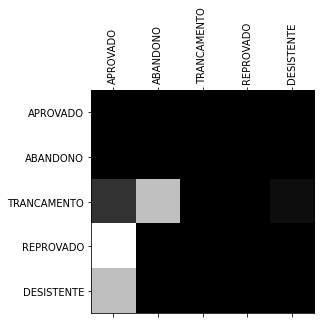

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 9423, 'ABANDONO': 4582, 'TRANCAMENTO': 153, 'REPROVADO': 1, 'DESISTENTE': 74}
{'APROVADO': 9509, 'ABANDONO': 4697, 'TRANCAMENTO': 0, 'REPROVADO': 0, 'DESISTENTE': 27}


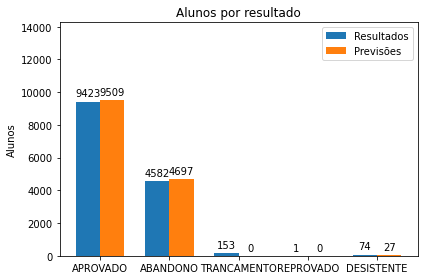

In [18]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


lin_reg = LinearSVC(dual=False, random_state=42)
train_and_evaluate(lin_reg, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)

lin_reg_gs = LinearSVC()

param_grid = [
    {'loss': ['hinge'], 'penalty':  ['l2'], 'max_iter': [1000, 10000]},
    {'loss': ['squared_hinge'], 'dual': [False], 'penalty':  ['l1', 'l2'], 'max_iter': [1000, 10000]}

]

#calculate_with_grid_search(lin_reg_gs, param_grid, treino_x, teste_x, treino_y, teste_y)


#### GaussianNB

A acurácia foi 29.90%
Tempo de execução:: 0.047385454177856445s


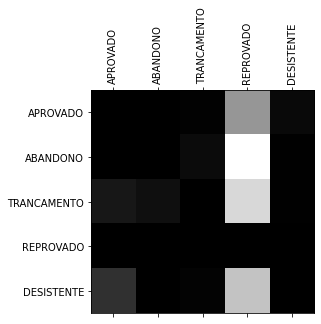

In [19]:
from sklearn.naive_bayes import GaussianNB

treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


gaussian_nb = GaussianNB()
train_and_evaluate(gaussian_nb, treino_x, teste_x, treino_y, teste_y)

#### RandomForestClassifier

A acurácia foi 98.97%
Tempo de execução:: 2.2583067417144775s


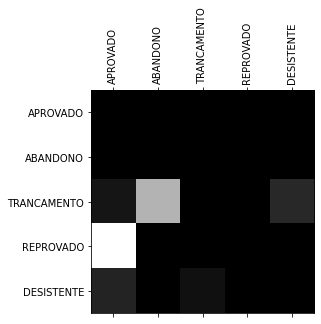

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 9531, 'ABANDONO': 4486, 'TRANCAMENTO': 134, 'REPROVADO': 2, 'DESISTENTE': 80}
{'APROVADO': 9555, 'ABANDONO': 4577, 'TRANCAMENTO': 16, 'REPROVADO': 0, 'DESISTENTE': 85}


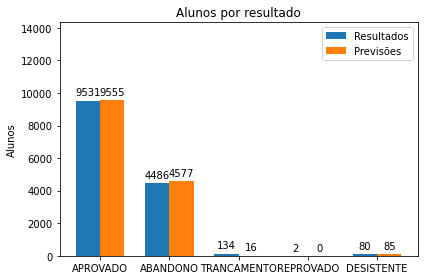

In [20]:
from sklearn.ensemble import RandomForestClassifier

treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


random_forest = RandomForestClassifier(random_state=42)
train_and_evaluate(random_forest, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)


param_grid = [
    {'bootstrap': [False], 'n_estimators': [10, 30, 100, 300], 'n_jobs':[-1]},
    {'n_estimators': [10, 30, 100, 300], 'n_jobs':[-1]}
]


random_forest_gs = RandomForestClassifier()


#calculate_with_grid_search(random_forest_gs, param_grid, treino_x, teste_x, treino_y, teste_y)


#### AdaBoostClassifier

A acurácia foi 97.18%
Tempo de execução:: 1.404357671737671s


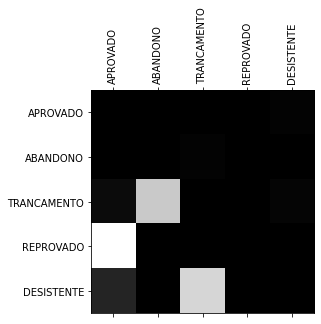

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 9385, 'ABANDONO': 4612, 'TRANCAMENTO': 137, 'REPROVADO': 1, 'DESISTENTE': 98}
{'APROVADO': 9276, 'ABANDONO': 4663, 'TRANCAMENTO': 160, 'REPROVADO': 12, 'DESISTENTE': 122}


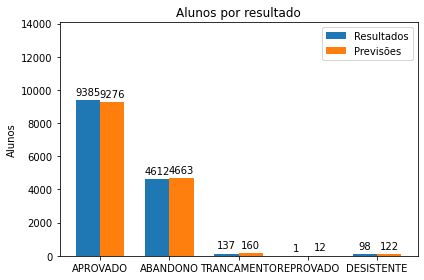

In [21]:
from sklearn.ensemble import AdaBoostClassifier

treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


adaboost = AdaBoostClassifier(random_state=42)
train_and_evaluate(adaboost, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)


param_grid = [
    {'learning_rate': [0.1, 0.3, 1, 3], 'n_estimators': [30, 10, 100], 'algorithm': ['SAMME'],},
    {'learning_rate': [0.1, 0.3, 1, 3], 'n_estimators': [10, 30, 100]} # Com o Samme.r, padrão
]


adaboost_cs = AdaBoostClassifier()

#calculate_with_grid_search(adaboost_cs, param_grid, treino_x, teste_x, treino_y, teste_y)


#### LogisticRegression

A acurácia foi 98.59%
Tempo de execução:: 3.603909492492676s


/home/eliasb/Documentos/evasao_escolar/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


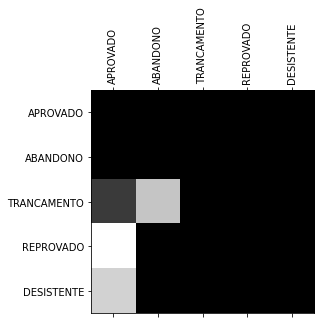

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 9512, 'ABANDONO': 4508, 'TRANCAMENTO': 132, 'REPROVADO': 2, 'DESISTENTE': 79}
{'APROVADO': 9609, 'ABANDONO': 4609, 'TRANCAMENTO': 1, 'REPROVADO': 0, 'DESISTENTE': 14}


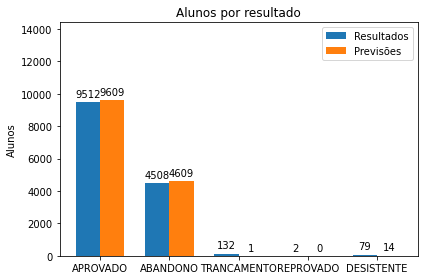

In [22]:
from sklearn.linear_model import LogisticRegression

treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


log_regression = LogisticRegression(random_state=42)
train_and_evaluate(log_regression, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)


param_grid = [
    {'C': [0.1, 1, 3], 'fit_intercept': [False, True], 'max_iter': [1000, 10000] },
    {'C': [0.1, 1, 3], 'solver': ['newton-cg'], 'max_iter': [1000, 10000]}
]


log_regression_cs = LogisticRegression()


#calculate_with_grid_search(log_regression_cs, param_grid, treino_x, teste_x, treino_y, teste_y)


#### DecisionTreeClassifier

A acurácia foi 98.76%
Tempo de execução:: 0.11612224578857422s


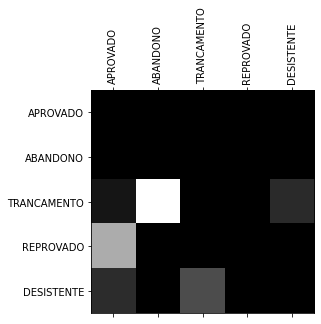

dict_keys([0, 1, 2, 3, 4])
{'APROVADO': 9540, 'ABANDONO': 4476, 'TRANCAMENTO': 129, 'REPROVADO': 2, 'DESISTENTE': 86}
{'APROVADO': 9540, 'ABANDONO': 4566, 'TRANCAMENTO': 43, 'REPROVADO': 3, 'DESISTENTE': 81}


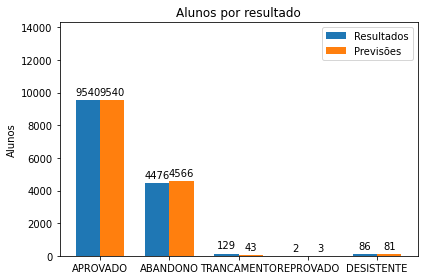

In [23]:
from sklearn.tree import DecisionTreeClassifier

treino_x, teste_x, treino_y, teste_y = train_test_split(subset, dados_filtrados_y, test_size=0.2)


dec_tree = DecisionTreeClassifier(random_state=42)
train_and_evaluate(dec_tree, treino_x, teste_x, treino_y, teste_y, show_distribuition = True)


param_grid = [
    {'splitter': ['random'], 'criterion': ['entropy'], 'max_features': ['auto', 'sqrt', 'log2'] }
]


dec_tree_cs = DecisionTreeClassifier()


#calculate_with_grid_search(dec_tree_cs, param_grid, treino_x, teste_x, treino_y, teste_y)
